# 오토인코더
**비지도학습을 위한 딥러닝 모델**
- 데이터의 숨겨진 구조를 발견해 노드의 수를 줄이는 것이 목표
- 입력 데이터에서 불필요한 특징들을 제거한 압축된 특징을 학습
- 오토인코더의 출력은 입력을 재구축한 것임
    - 최대한 비슷하게 나오도록 학습
    - 입력 데이터와 예상 출력 데이터가 동일
        - 입력 == 레이블



## 케라스를 이용한 오토인코더 실습
- 다양한 프레임워크 위에서 동작하는 상위레벨 딥러닝 프레임워크

**Keras API 사용**
- Sequential 모델 API
    - 하나의 입력, 출력 순차 레이어 스택을 지원

- Functional API
    - 레고블록 모델
    - 다중 입력, 다중 출력, 임의의 그래프 구조 지원
- Model Subclassing
    - 가장 Flexible

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 256
x_test = x_test.astype('float32') / 256

x_train.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [3]:
# flatten
x_train = x_train.reshape(len(x_train), 28 * 28)
x_test = x_test.reshape(len(x_test), 28 * 28)

x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [4]:
input_layer = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_layer)
decoded = Dense(784, activation='sigmoid')(encoded)

In [5]:
auto_encoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

In [6]:
input_layer_decoder = Input(shape=(64,))
decoder_layer = auto_encoder.layers[-1](input_layer_decoder)
decoder = Model(input_layer_decoder, decoder_layer)

In [7]:
auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [8]:
auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')
auto_encoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/50
235/235 [==============================] - 8s 7ms/step - loss: 0.2481 - val_loss: 0.1651
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1461 - val_loss: 0.1292
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1207 - val_loss: 0.1109
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1062 - val_loss: 0.0997
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0969 - val_loss: 0.0921
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0904 - val_loss: 0.0867
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0858 - val_loss: 0.0831
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0827 - val_loss: 0.0807
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0806 - val_loss: 0.0790
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0791 - val_loss: 0.0778

In [9]:
encoded_images = encoder.predict(x_test)
decoded_images = decoder.predict(encoded_images)

313/313 [==============================] - 0s 1ms/step


In [13]:
def visualize(data, size):
    n = 8
    plt.figure(figsize=(20, 4))
    plt.gray()
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(size, size))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

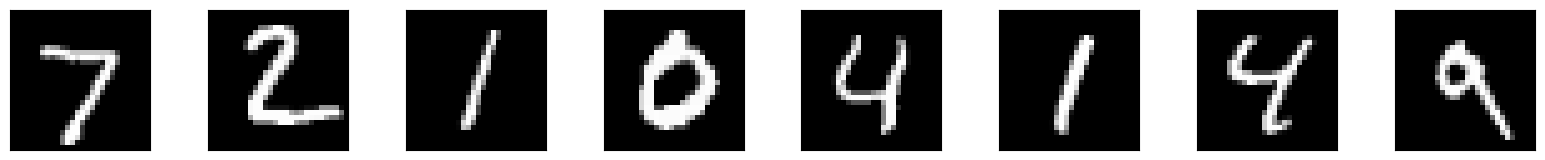

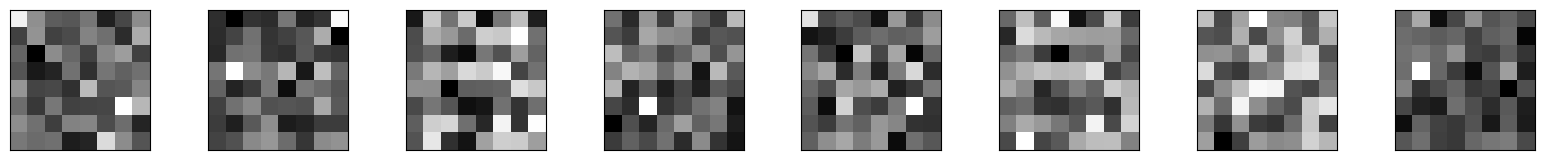

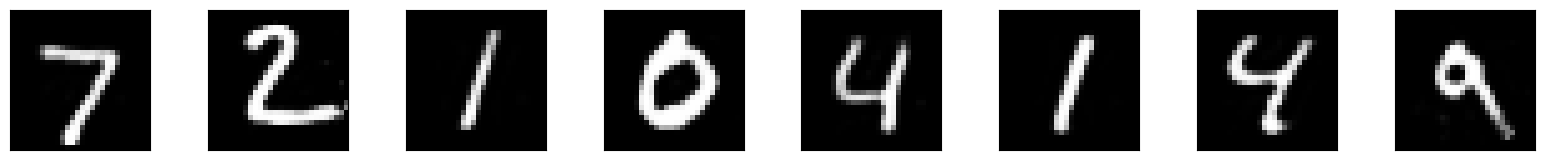

In [14]:
visualize(x_test, 28)
visualize(encoded_images, 8)
visualize(decoded_images, 28)

## 무비렌즈 데이터셋 평점 정보 예측 딥러닝 모델 생성
- 영화의 수 9,066개
- 영화ID 범위 1 ~ 163949
- 영화ID를 0 ~ 9065로 인덱싱

- 영화 -> 임베딩 -> 최종 영화
- 사용자 -> 임베딩 -> 최종 사용자
위 둘을 내적하여 유사도 평가

In [15]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

In [16]:
ratings = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv")

In [17]:
ratings.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [18]:
ratings.shape

(100004, 4)

In [19]:
users = len(ratings.userId.unique())
movies = len(ratings.movieId.unique())
users, movies

(671, 9066)

In [20]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [21]:
movieID_to_seqID = {}
seqID_to_movieID = {}
for sid, id in enumerate(ratings["movieId"].unique()):
    seqID_to_movieID[sid] = id
    movieID_to_seqID[id] = sid

In [22]:
def return_movidId_to_seqId(row):
    return movieID_to_seqID[row.movieId]

ratings['new_movieId'] = ratings.apply(return_movidId_to_seqId, axis=1)

In [24]:
ratings.describe()

,userId,movieId,rating,timestamp,new_movieId
count,100004.000000,100004.000000,100004.000000,1.000040e+05,100004.000000
mean,347.011310,12548.664363,3.543608,1.129639e+09,1660.778349
std,195.163838,26369.198969,1.058064,1.916858e+08,1893.955817
min,1.000000,1.000000,0.500000,7.896520e+08,0.000000
25%,182.000000,1028.000000,3.000000,9.658478e+08,327.000000
50%,367.000000,2406.500000,4.000000,1.110422e+09,873.000000
75%,520.000000,5418.000000,4.000000,1.296192e+09,2344.000000
max,671.000000,163949.000000,5.000000,1.476641e+09,9065.000000


In [25]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=0.2, random_state=42)

In [26]:
train.head()

,userId,movieId,rating,timestamp,new_movieId
37865,273,5816,4.5,1466946328,364
46342,339,2028,4.5,1446663181,113
64614,461,3895,0.5,1093224965,4626
41974,300,3578,4.5,1086010878,468
50236,369,292,3.0,847465462,48


In [27]:
test.head()

,userId,movieId,rating,timestamp,new_movieId
19090,128,1028,5.0,1049690908,165
99678,665,4736,1.0,1010197684,9064
18455,120,4002,3.0,1167420604,2763
35755,257,1274,4.0,1348544094,2190
66536,468,6440,4.0,1296191715,1333


In [29]:
# 영화 레이어
movie_input = Input(shape=[1], name="Movies")
movie_embedding = Embedding(movies+1, 5, name="Embedding_Movies")(movie_input)
movie_final = Flatten(name="Flatten_Movies")(movie_embedding)

In [31]:
# 사용자 레이어
user_input = Input(shape=[1], name="Users")
user_embedding = Embedding(users+1, 5, name="Embedding_Users")(user_input)
user_final = Flatten(name="Flatten_Users")(user_embedding)

In [33]:
# 내적 레이어
mult = Dot(name="Dot_Product", axes=1)([movie_final, user_final])

In [35]:
from keras.losses import mean_squared_error
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

model = Model([movie_input, user_input], mult)
model.compile(optimizer='adam', loss=root_mean_squared_error)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Movies (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Users (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Embedding_Movies (Embedding)   (None, 1, 5)         45335       ['Movies[0][0]']                 
                                                                                                  
 Embedding_Users (Embedding)    (None, 1, 5)         3360        ['Users[0][0]']                  
                                                                                            

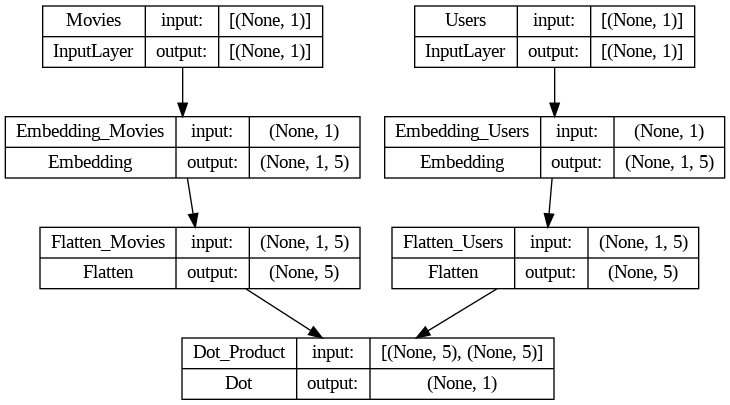

In [37]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

Epoch 1/10
2501/2501 [==============================] - 15s 6ms/step - loss: 3.3328
Epoch 2/10
2501/2501 [==============================] - 15s 6ms/step - loss: 1.9312
Epoch 3/10
2501/2501 [==============================] - 18s 7ms/step - loss: 1.2596
Epoch 4/10
2501/2501 [==============================] - 22s 9ms/step - loss: 0.9969
Epoch 5/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.8716
Epoch 6/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.8023
Epoch 7/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.7597
Epoch 8/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.7301
Epoch 9/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.7090
Epoch 10/10
2501/2501 [==============================] - 10s 4ms/step - loss: 0.6929


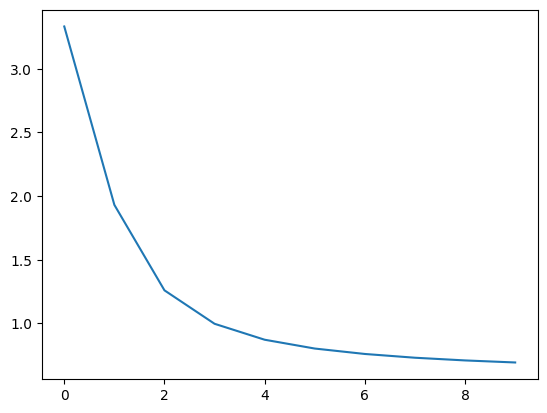

In [38]:
from keras.models import load_model

history = model.fit([train.new_movieId, train.userId], train.rating, epochs=10, verbose=1)
model.save(r"recommender_model.h5")
plt.plot(history.history['loss'])
plt.xlabel = ("Epochs")
plt.ylabel = ("Training_Error")

In [39]:
model.evaluate([test.new_movieId, test.userId], test.rating)

626/626 [==============================] - 2s 2ms/step - loss: 0.8097


0.8096951842308044

In [41]:
predictions = model.predict([test.new_movieId.head(8), test.userId.head(8)])

1/1 [==============================] - 0s 227ms/step


In [42]:
predictions

array([[ 4.8154488 ],
       [ 0.01240825],
       [ 3.3947973 ],
       [ 3.8673666 ],
       [ 3.2260492 ],
       [ 3.9217553 ],
       [ 3.7287917 ],
       [-0.01207391]], dtype=float32)

In [44]:
for i in range(8):
    print(predictions[i], test.rating.iloc[i])

[4.8154488] 5.0
[0.01240825] 1.0
[3.3947973] 3.0
[3.8673666] 4.0
[3.2260492] 4.0
[3.9217553] 5.0
[3.7287917] 5.0
[-0.01207391] 4.0
